<a href="https://colab.research.google.com/github/21092004Goda/data_anal/blob/main/Lab_1_Computer_Vision_and_Pattern_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Лабораторная работа 1.**
#### *Сбор, визуализация и анализ данных по графу*

In [6]:
%%capture
!pip install feedparser

In [7]:
import feedparser
import urllib.request as libreq
import pandas as pd

In [8]:
# data collection

with libreq.urlopen('http://export.arxiv.org/api/query?search_query=all:cs.CV&start=0&max_results=50') as url:
  r = url.read()
print(r)

b'<?xml version="1.0" encoding="UTF-8"?>\n<feed xmlns="http://www.w3.org/2005/Atom">\n  <link href="http://arxiv.org/api/query?search_query%3Dall%3Acs.CV%26id_list%3D%26start%3D0%26max_results%3D50" rel="self" type="application/atom+xml"/>\n  <title type="html">ArXiv Query: search_query=all:cs.CV&amp;id_list=&amp;start=0&amp;max_results=50</title>\n  <id>http://arxiv.org/api/bBL2Cs9TmIhkftl84JZbo9zt+1Y</id>\n  <updated>2025-09-22T00:00:00-04:00</updated>\n  <opensearch:totalResults xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">167528</opensearch:totalResults>\n  <opensearch:startIndex xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">0</opensearch:startIndex>\n  <opensearch:itemsPerPage xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">50</opensearch:itemsPerPage>\n  <entry>\n    <id>http://arxiv.org/abs/0903.0134v2</id>\n    <updated>2010-01-08T10:32:52Z</updated>\n    <published>2009-03-01T11:10:27Z</published>\n    <title>Recognition of Regular Shapes in Sateli

In [9]:
# unique titles

docs = feedparser.parse(r)
titles = [d["title"] for d in docs["entries"]]
len(set(titles))

50

Загрузка

In [10]:
%%time
# keywords extraction

from transformers import pipeline

pipe = pipeline("text2text-generation", model="ilsilfverskiold/tech-keywords-extractor")

Device set to use cuda:0


CPU times: user 1.08 s, sys: 266 ms, total: 1.35 s
Wall time: 4.06 s


In [11]:
%time
# data extraction example

doc = feedparser.parse(r)
title = doc['entries'][0]['title']
abstract = doc['entries'][0]['summary']
authors = [author['name'] for author in doc['entries'][0]['authors']]
tags = [tag['term'] for tag in doc['entries'][0]['tags']]

keywords = pipe(abstract)[0]["generated_text"].split(", ")


print(f"Title: {title}\n\nAuthors: {authors}\n\nAbstract: {abstract}\n\nTags: {tags}\n\nKeywords: {keywords}")

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs
Title: Recognition of Regular Shapes in Satelite Images

Authors: ['Ahmad Reza Eskandari', 'Ali Pourmohammad']

Abstract: This paper has been withdrawn by the author ali pourmohammad.

Tags: ['cs.CV']

Keywords: ['Paper', 'Ali Pourmohammad']


In [12]:
%time

pubs = []
for entry in docs["entries"]:
  data = {"title": entry['title'],
          "abstract": entry['summary'],
          "authors": [author['name'] for author in entry['authors']],
          "tags": [tag['term'] for tag in entry['tags']]}
  pubs.append(data)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


In [13]:
df = pd.DataFrame(pubs)
df

,title,abstract,authors,tags
0,Recognition of Regular Shapes in Satelite Images,This paper has been withdrawn by the author al...,"[Ahmad Reza Eskandari, Ali Pourmohammad]",[cs.CV]
1,Convolutional Matching Pursuit and Dictionary ...,Matching pursuit and K-SVD is demonstrated in ...,"[Arthur Szlam, Koray Kavukcuoglu, Yann LeCun]",[cs.CV]
2,Template Matching based Object Detection Using...,This article provides a step by step developme...,[Anish Acharya],[cs.CV]
3,Exploration of object recognition from 3D poin...,We present our latest experiment results of ob...,[Lin Duan],[cs.CV]
4,Brain MRI Image Super Resolution using Phase S...,A hallucination-free and computationally effic...,"[Sifeng He, Bahram Jalali]",[cs.CV]
5,Blurred Images Lead to Bad Local Minima,Blurred Images Lead to Bad Local Minima,"[Gal Katzhendler, Daphna Weinshall]",[cs.CV]
6,BMVC 2019: Workshop on Interpretable and Expla...,Proceedings of the BMVC 2019 Workshop on Inter...,[Alun Preece],"[cs.CV, cs.AI, cs.LG]"
7,Covapixels,We propose and discuss the summarization of su...,[Jeffrey Uhlmann],[cs.CV]
8,Advances of Scene Text Datasets,This article introduces publicly available dat...,[Masakazu Iwamura],[cs.CV]
9,Detecting speaking persons in video,We present a novel method for detecting speaki...,[Hannes Fassold],[cs.CV]


In [14]:
%%time
df["keywords"] = df["abstract"].apply(lambda x: pipe(x)[0]["generated_text"].split(", "))

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


CPU times: user 17.4 s, sys: 0 ns, total: 17.4 s
Wall time: 24 s


In [15]:
df["authors"] = df["authors"].apply(lambda x: ", ".join(x))
df["tags"] = df["tags"].apply(lambda x: ", ".join(x))
df["keywords"] = df["keywords"].apply(lambda x: ", ".join(x))

df

,title,abstract,authors,tags,keywords
0,Recognition of Regular Shapes in Satelite Images,This paper has been withdrawn by the author al...,"Ahmad Reza Eskandari, Ali Pourmohammad",cs.CV,"Paper, Ali Pourmohammad"
1,Convolutional Matching Pursuit and Dictionary ...,Matching pursuit and K-SVD is demonstrated in ...,"Arthur Szlam, Koray Kavukcuoglu, Yann LeCun",cs.CV,"Matching Pursuit, K-SVD, Translation invariant"
2,Template Matching based Object Detection Using...,This article provides a step by step developme...,Anish Acharya,cs.CV,"ObjectDetection, HOG, Feature Pyramid, Templat..."
3,Exploration of object recognition from 3D poin...,We present our latest experiment results of ob...,Lin Duan,cs.CV,"Object Recognition, 3D Point Cloud, Moving Car"
4,Brain MRI Image Super Resolution using Phase S...,A hallucination-free and computationally effic...,"Sifeng He, Bahram Jalali",cs.CV,"Brain MRI, Algorithm, Resolution Enhancement"
5,Blurred Images Lead to Bad Local Minima,Blurred Images Lead to Bad Local Minima,"Gal Katzhendler, Daphna Weinshall",cs.CV,"Blurred Images, Local Minima"
6,BMVC 2019: Workshop on Interpretable and Expla...,Proceedings of the BMVC 2019 Workshop on Inter...,Alun Preece,"cs.CV, cs.AI, cs.LG","BMVC, Interpretable Machine Vision, Explainabl..."
7,Covapixels,We propose and discuss the summarization of su...,Jeffrey Uhlmann,cs.CV,"Superpixel-type imagetiles, covapixels, mean a..."
8,Advances of Scene Text Datasets,This article introduces publicly available dat...,Masakazu Iwamura,cs.CV,"Text Detection, Text Recognition, Datasets"
9,Detecting speaking persons in video,We present a novel method for detecting speaki...,Hannes Fassold,cs.CV,"Neural Network, Video Detection, Facial Lenses"


In [16]:
df.to_csv("multimedia_250.csv", index=False)

Граф

In [17]:
import pandas as pd
import networkx as nx
from itertools import combinations, chain
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from operator import itemgetter
import plotly.graph_objects as go

In [18]:
df = pd.read_csv("multimedia_250.csv")
df.sample(5)

,title,abstract,authors,tags,keywords
43,Anomaly Detection Based on Deep Learning Using...,This paper proposes an anomaly detection metho...,"Satoshi Hashimoto, Yonghoon Ji, Kenichi Kudo, ...",cs.CV,"Anomaly Detection, Machine Learning, Industria..."
20,Convolutional Neural Networks learn compact lo...,A standard deep convolutional neural network p...,"Christian Osendorfer, Justin Bayer, Patrick va...",cs.CV,"Deep Convolutional Neural Network, Local Image..."
10,Cycle-GAN for eye-tracking,This manuscript presents a not typical impleme...,Ildar Rakhmatulin,"cs.CV, cs.AI","Cycle-GAN, Eye Tracking"
29,The HASYv2 dataset,This paper describes the HASYv2 dataset. HASY ...,Martin Thoma,cs.CV,"HASYv2, MNIST, Classification Challenge, Verif..."
41,New Radon Transform Based Texture Features of ...,"In this paper, we present some new features de...","Rustam Latypov, Evgeni Stolov",cs.CV,"Radon Transform, Handwritten Document, Texture..."


In [19]:
klist = [[word.strip() for word in keywords.split(",") if word]
         for keywords in df["keywords"].tolist()]
klist[:3]

[['Paper', 'Ali Pourmohammad'],
 ['Matching Pursuit', 'K-SVD', 'Translation invariant'],
 ['ObjectDetection', 'HOG', 'Feature Pyramid', 'Template Matching']]

In [20]:
edges = list(chain(*[list(combinations(words, 2)) for words in klist]))
edges = [tuple(sorted(edge)) for edge in edges]
weighted_edges = [(edge[0], edge[1], {"weight": edges.count(edge)}) for edge in set(edges)]
weighted_edges[:10]

[('Computing', 'Control Applications', {'weight': 1}),
 ('Deep Convolutional Neural Network',
  'Local Image Descriptors',
  {'weight': 1}),
 ('Adaboost', 'FER', {'weight': 1}),
 ('Catchment Basin', 'Minima', {'weight': 1}),
 ('Facial Lenses', 'Neural Network', {'weight': 1}),
 ('Brick Finding', 'Wavelet Analysis', {'weight': 1}),
 ('ECG', 'EKG', {'weight': 1}),
 ('FER', 'Feature Selection', {'weight': 1}),
 ('BMVC', 'Interpretable Machine Vision', {'weight': 1}),
 ('CCCA', 'Communications', {'weight': 1})]

In [21]:
len(set(edges)), len(weighted_edges)

(159, 159)

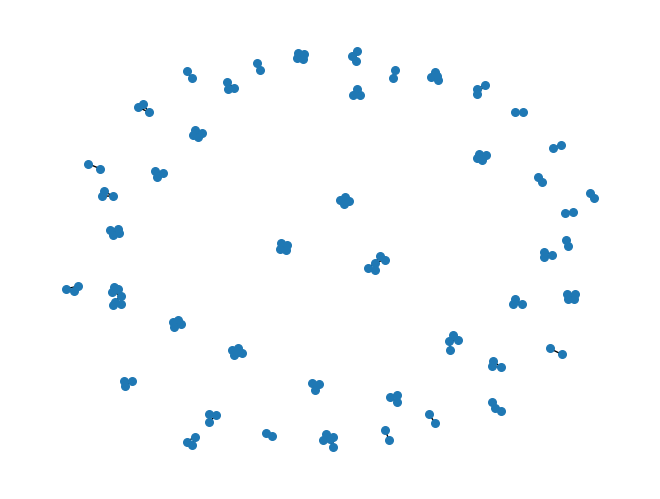

In [22]:
G = nx.Graph()
G.add_edges_from(weighted_edges)
nx.draw(G, with_labels=False, font_weight='bold', node_size=30)

In [23]:
communities = nx.community.louvain_communities(G, resolution=0.9)
print(f"# of clusters: {len(communities)}, Modularity: {nx.community.modularity(G, communities)}")

# of clusters: 45, Modularity: 0.9663979013155357


In [24]:
comm_data = [{"n_of_nodes": len(comm), "nodes": comm} for comm in communities]
cdf = pd.DataFrame(comm_data)
cdf.describe()

,n_of_nodes
count,45.000000
mean,3.133333
std,1.078720
min,2.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,7.000000


In [25]:
top3_comm = cdf.nlargest(3, "n_of_nodes")
top3_comm

,n_of_nodes,nodes
8,7,"{HOG, Cross-correlation, Sum of Squared, Kunch..."
2,5,"{Facial Expression Recognition, FER, Adaboost,..."
9,5,"{Validation, Skin Lesion Analysis, ISBIChallen..."


In [26]:
nodes = list(chain(*top3_comm["nodes"].tolist()))
S = G.subgraph(nodes)

In [27]:
def create_community_node_colors(graph, communities):
    colors = list(set(mcolors.TABLEAU_COLORS.values()))
    node_colors = []
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                break
            current_community_index += 1
    return node_colors

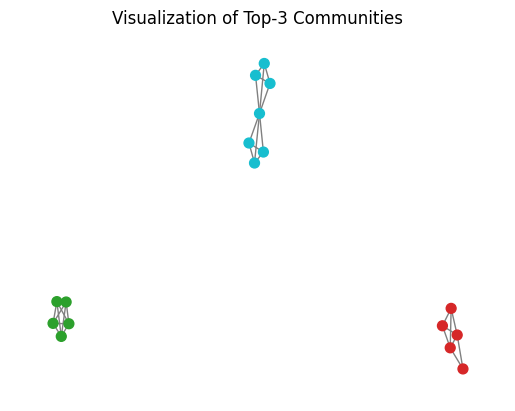

In [28]:
def visualize_communities(graph, communities, i):
    node_colors = create_community_node_colors(graph, communities)
    title = f"Visualization of Top-3 Communities"
    pos = nx.spring_layout(graph, iterations=100, seed=23)
    plt.title(title)
    nx.draw(
        graph,
        pos=pos,
        node_size=50,
        node_color=node_colors,
        edge_color="gray"
    )

visualize_communities(S, top3_comm["nodes"].tolist(), 1)

In [29]:
communities = top3_comm["nodes"].tolist()
pos = nx.spring_layout(S, iterations=100, seed=23)

# edges coordinates
x_nodes, y_nodes = zip(*pos.values())
edge_x, edge_y = [], []
for edge in S.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# degree labels
node_labels = [f"Node {n}<br>Degree: {S.degree(n)}" for n in S.nodes()]
node_degrees = [S.degree(n) for n in S.nodes()]
node_colors_list = create_community_node_colors(S, communities)

fig = go.Figure()
# add edges
fig.add_trace(go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color="gray"),
))

# add nodes
fig.add_trace(go.Scatter(
    x=x_nodes, y=y_nodes, mode="markers",
    marker=dict(size=[deg*1.1+5 for deg in node_degrees], color=node_colors_list),
    hoverinfo="text",
    text=node_labels
))

# background settings
fig.update_layout(
    title=f"Interactive Visualization of Top-3 Communities",
    showlegend=False,
    plot_bgcolor="white",
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
)

fig.show()

Оценка

In [30]:
# top-10 nodes by degree centrality
[(node[0], round(node[1],2))
for node in sorted(nx.degree_centrality(S).items(), key=itemgetter(1), reverse=True)][:10]

[('Template Matching', 0.38),
 ('Skin Lesion Analysis', 0.25),
 ('Facial Expression Recognition', 0.25),
 ('FER', 0.25),
 ('Adaboost', 0.25),
 ('Melanoma Detection', 0.25),
 ('Feature Selection', 0.25),
 ('Synergetic Prototype', 0.25),
 ('Validation', 0.19),
 ("Kunchenko's Polynomials", 0.19)]

In [31]:
# top nodes by degree centrality in top-3 communities

for i, nodes in enumerate(top3_comm["nodes"].tolist(), start=1):
  s = G.subgraph(nodes)
  top_node = max(nx.degree_centrality(s).items(), key=itemgetter(1))

  top3_nodes = [(node[0], round(node[1],2))
  for node in sorted(nx.degree_centrality(s).items(), key=itemgetter(1), reverse=True)][:3]

  print(f"# of cluster: {i}, Central node by degree: {(top_node[0], round(top_node[1], 2))}")
  print(f"Top-3 nodes: {top3_nodes}\n")


# of cluster: 1, Central node by degree: ('Template Matching', 1.0)
Top-3 nodes: [('Template Matching', 1.0), ("Kunchenko's Polynomials", 0.5), ('ObjectDetection', 0.5)]

# of cluster: 2, Central node by degree: ('Facial Expression Recognition', 1.0)
Top-3 nodes: [('Facial Expression Recognition', 1.0), ('FER', 1.0), ('Adaboost', 1.0)]

# of cluster: 3, Central node by degree: ('Skin Lesion Analysis', 1.0)
Top-3 nodes: [('Skin Lesion Analysis', 1.0), ('Melanoma Detection', 1.0), ('Validation', 0.75)]

